# Necessary packages 

In [ ]:
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn
!pip install plotly
!pip install autoviz
!pip install dataprep
!pip install ydata-profiling

# Loading Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split


In [155]:
# Creating train and test data sets (from GitHub, no need to add it manually)
url = 'https://raw.githubusercontent.com/AnastasiaDv491/AA-datasets/main/train.csv'

full_data_set = pd.read_csv(url)

target_price = full_data_set['target']
feature_full = full_data_set.drop('target', axis=1)
feature_train, feature_test, target_train, target_test = train_test_split(feature_full, target_price, random_state=1)

matrix_train = feature_train.join(target_train,on="property_id")
#test


In [ ]:

full_data_set.head()
full_data_set.tail()


# Exploratory Data Analysis (EDA) (DO NOT RUN, VERY SLOW)

In [ ]:
full_data_set.shape     ##(6495, 55)

## looking at a few measures

full_data_set.describe()

full_data_set.nunique()

full_data_set['host_response_time'].unique()

full_data_set.isnull().sum()  ## quite a few variables can be dropped



In [ ]:
## variables that need to be dropped, shall be commented out below

df = full_data_set[['property_id', 'property_name', 'property_summary', 'property_space',
       'property_desc', 'property_neighborhood', 'property_notes',
       'property_transit', 'property_access', 'property_interaction',
       'property_rules', 'property_zipcode', 'property_lat', 'property_lon',
       'property_type', 'property_room_type', 'property_max_guests',
       'property_bathrooms', 'property_bedrooms', 'property_beds',
       'property_bed_type', 'property_amenities', 'property_sqfeet',
       'property_scraped_at', 'property_last_updated', 'host_id', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_nr_listings', 'host_nr_listings_total',
       'host_verified', 'booking_price_covers', 'booking_min_nights',
       'booking_max_nights', 'booking_availability_30',
       'booking_availability_60', 'booking_availability_90',
       'booking_availability_365', 'booking_cancel_policy', 'reviews_num',
       'reviews_first', 'reviews_last', 'reviews_rating', 'reviews_acc',
       'reviews_cleanliness', 'reviews_checkin', 'reviews_communication',
       'reviews_location', 'reviews_value', 'reviews_per_month', 'extra',
       'target']].copy()

df.head()



In [ ]:

## Relationship analysis

correlation = df.corr()
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True)

In [ ]:
df.dtypes

From here on we will proceed with only the train features in order to avoid any data spillage

## Autoviz

[Documentation](https://www.kaggle.com/general/233832)

In [ ]:
# importing Autoviz class
from autoviz.AutoViz_Class import AutoViz_Class #Instantiate the AutoViz class
AV = AutoViz_Class()

In [ ]:
eda=AV.AutoViz(filename="",dfte=matrix_train, chart_format='html')

In [ ]:
eda_feature_train = AV.AutoViz(filename="",dfte=feature_train, chart_format='html')
eda_feature_train

In [ ]:
eda_target_train = AV.AutoViz(filename="",dfte=target_train, chart_format='html')
eda_target_train

## EDA using DataPrep

In [ ]:
from dataprep.eda import create_report

target_report = create_report(target_train)
target_report

In [ ]:
target_report.show_browser()

In [ ]:
feature_report = create_report(feature_train)
feature_report

In [ ]:
feature_report.show_browser()

In [ ]:
matrix_report = create_report(matrix_train)
matrix_report

In [ ]:
matrix_report.show_browser()

## Ydata-profling (Former pandas-profling)

[Documentation](https://ydata-profiling.ydata.ai/docs/master/pages/getting_started/quickstart.html#using-inside-jupyter-notebooks)

In [ ]:
from ydata_profiling import ProfileReport

In [ ]:
profile = ProfileReport(matrix_train,title="Pandas Profiling Report")

### Widgets

In [ ]:
profile.to_widgets()

### HTML

In [ ]:
profile.to_notebook_iframe()
profile.to_file("Ydata_report.html")

In [ ]:
profile.to_file("Ydata_report.html")

# Preprocessing

## Pipeline for feature processing (unused)

Only figured out how to use pipelines too late into project
Decided to just use old, less efficient way instead

In [187]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder

df = feature_train.copy()

non_numeric_cols= ['property_type',
 'property_room_type',
 'property_bed_type',
 'host_response_time',
 'booking_cancel_policy',
 'reviews_first',
 'reviews_last',
 'property_last_updated_bucket',
 'host_nr_listings_cat',
 'property_bathrooms_cat',
 'propety_beds_cat',
 'property_bedrooms_cat',
 'reviews_cleanliness_n',
 'reviews_checkin_n',
 'reviews_location_n',
 'reviews_communication_n',
 'reviews_value_n']

def isMissing(df, col, new_col):
  df[new_col] = np.where(df[col].isna(), 1, 0)
  return df


class toLowerCase():
  def __init__(self, columns=None):
    self.columns = columns
    
  def fit(self, X, y=None):
      return self
  
  def transform(self,X, y= None):
    X = X.apply(lambda x: x.str.lower() if x.dtype=='object' else x)

    return X

def SummaryMissing(df, col, new_col):
  df[new_col] = np.where(df[col].str.split().str.len() == 1, 1, 0)
  df[new_col] = np.where(df[col].isna(), 1, 0)   
  return df
  
def splitCountWords(df, cols):
  for col in cols:
    df[col] = df[col].str.replace('\d+', '').replace('[^\w\s]',' ')
    df[col] = df[col].str.split().str.len()
    df[col] = df[col].fillna(0)

  return df

def columnDropperTransformer(df, cols):
  df = df.drop(cols, axis=1)
  return df
    
def featureGrouping(df, col):
  threshold_percent = 3

  series = pd.value_counts(df['property_type'])
  mask = (series / series.sum() * 100).lt(threshold_percent)

  df= df.assign(col = np.where(df[col].isin(series[mask].index),'Other', df[col]))
  return df 

def replaceWithMode(df, cols):
  for col in cols:
      df[col]= df[col].fillna(df[col].mode()[0])
  return df

def replacewithZero(df, cols):
  for col in cols:
    df[col] = df[col].fillna(0)
  return df

def removeSpaces(df, cols):
  for col in cols:
    df[col] = df[col].replace(' ', '')
  return df

def BathroomsCount(df, col,new_col):
  df[new_col]= 'One'
  df.loc[(df[col] < 1) , new_col] = 'None'
  df.loc[(df[col] > 1), new_col] = 'More than one'

  df = df.drop([col], axis = 1)
  return df

def NumToCategory(df, cols,new_cols):
  for col, new_col in zip(cols, new_cols):
    conditions = [
      (df[col]==1),
      (df[col]==2),
      (df[col]==3),
      (df[col]>3)
    ]
    choices = ['One', 'Two', 'Three', 'More than three']
    df[new_col] = np.select(conditions, choices) 
  return df

def reviewRecoding(df, cols, new_cols):
  for col, new_col in zip(cols, new_cols):
    df[new_col] = df[col].fillna("Average") # average
    df.loc[(df[col] == 5) , new_col] = 'Average'

    df.loc[(df[col] < 5) , new_col] = 'Bad'
    df.loc[(df[col] > 5), new_col] = 'Good'
    df = df.drop([col], axis = 1)
  return df

def change_datetime_format(df,cols):
  for col in cols:
    df[col] = pd.to_datetime(df[col])
  return df

def add_scrapped_weekday(df,cols,new_cols):
  df[new_cols] = df[cols].dt.weekday
  return df

def last_updated_wrap(df,col,new_col):
  def last_updated_conversion(update_var:str):
    # 3 Buckets evenly distributed based on train, 2 for > 3 months, 0 for updated yesterday/today
    if "never" in update_var:
      return "3 months or more"
    elif "month" in update_var:
      if int(update_var.split(" ")[0])>=3:
        return "3 months or more"
      else:
        return "1 week to 3 months"
    elif "week" in update_var:
      return "1 week to 3 months"
    else: # This catches yesterday etc. is actually equivalent to "day" in update_var
      return "Within days"
  df[new_col] = [last_updated_conversion(x) for x in df[col]] 
  df = df.drop([col], axis = 1) # Dropping old column
  return df

def splitOnComma(df, col):
  df[col] =  df[col].str.split(', ').str.len()
  return df

# #TODO: you have to include those columns as arguments you pass to the function. then you pass teh original names of the cols to the function transformer

def host_since_transform(df,col):
  df[col] = df[col].fillna(df[col].mean()) # Simply imputing with mean, only had 1 NA anyways
  df['host_since_scraped'] = df['property_scraped_at']-df['host_since']
  df['host_since_scraped'] = df['host_since_scraped'].dt.days.astype('int16')
  df = df.drop(['host_since'], axis = 1) # Dropping old columns
  return df 

def missing_cat(df,col):
  # Just adds "Missing" as categorical value
  df[col].fillna(value="Missing",inplace=True)
  return df

def missing_to_100(df,col):
  df[col]=df[col].fillna(value=100)
  return df

def listing_number_transform(df,col,new_col):
  df.loc[(df[col] <= 1) , new_col] = 'One or less'
  df.loc[(df[col].isna()) , new_col] = 'One or less'
  df.loc[(df[col] > 1) & (df[col] <=3), new_col] = 'Two to Three'
  df.loc[(df[col] > 3), new_col] = 'More than 3'

  df = df.drop([col], axis = 1)
  return df 

def min_nights_transform(df,col):
  df = df[df[col]<30]
  return df

def max_nights_transform(df,col):
  df.loc[df[col] >60, col] = 60
  return df

def booking_availability_transform(df,col):
  df[col] = df[col]-df['booking_availability_90']
  df['booking_availability_90'] = df['booking_availability_90'] - df['booking_availability_60']
  df['booking_availability_60'] = df['booking_availability_60']- df['booking_availability_30']
  return df

def one_hot_func(df,col):
  dummie_cols = pd.get_dummies(df[col])
  df = pd.concat([df,dummie_cols], axis=1)
  df = df.drop(col, axis=1)
  return df 

def zip_func(df,col):
  df[col] = df[col].replace(' ','')
  dummies = pd.get_dummies(df[col])
  sorted_dummies = dummies[dummies.sum().sort_values(ascending=False).index]
  df = pd.concat([df,sorted_dummies.iloc[:,:10]],axis=1)
  df = df.drop(col, axis=1)
  return df

In [188]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(
     steps=[
        ('columnDropper', FunctionTransformer(columnDropperTransformer, kw_args={'cols':['property_id','property_space','property_desc','property_neighborhood','property_notes','property_access',
                                     "property_interaction","property_rules","host_location","host_about","host_id", 'property_transit', 'property_lon', 
                                     'property_lat', 'property_sqfeet',"host_nr_listings_total","extra"]})),
        # Drops min nights outliers
        ("min_nights_transform",FunctionTransformer(min_nights_transform,kw_args={'col':'booking_min_nights'})),
    
        ("change_datetime_format", FunctionTransformer(change_datetime_format,kw_args={'cols':['property_scraped_at','host_since','reviews_first','reviews_last']})),
        ("summaryMissing", FunctionTransformer(SummaryMissing, kw_args={'col':'property_summary','new_col':'property_summary_miss'})),
        ("missing_cat",FunctionTransformer(missing_cat,kw_args={'col':'host_response_time'})),
        ("missing_to_100",FunctionTransformer(missing_to_100,kw_args={'col':'host_response_rate'})),
        ("booking_availability_transform", FunctionTransformer(booking_availability_transform,kw_args={'col':'booking_availability_365'})),
        
        ("add_scrapped_weekday",FunctionTransformer(add_scrapped_weekday,kw_args={'cols':'property_scraped_at','new_cols':'scraped_weekday'})),
        ("last_updated_wrap",FunctionTransformer(last_updated_wrap,kw_args={'col':'property_last_updated','new_col':'property_last_updated_bucket'})),
        ("listing_number_transform", FunctionTransformer(listing_number_transform,kw_args={'col':'host_nr_listings','new_col':'host_nr_listings_cat'})),
        ('splitOnComma', FunctionTransformer(splitOnComma, kw_args={'col':'property_amenities'})),
        # # replacing missing with mode
        ("replaceWithMode", FunctionTransformer(replaceWithMode, kw_args={'cols': ['property_zipcode', 'property_bathrooms', 'reviews_per_month',
                                                                                   'host_since','reviews_first','reviews_last','reviews_rating','reviews_acc']})),
        ('removeSpaces', FunctionTransformer(removeSpaces, kw_args={'cols': ['property_zipcode']}))  ,                                                                         
        ("max_nights_transform", FunctionTransformer(max_nights_transform,kw_args={'col':'booking_max_nights'})),
        # # replacing missing with zero
        ('replaceWithZero', FunctionTransformer(replacewithZero, kw_args ={'cols':['property_beds', 'property_bedrooms','property_amenities']})),
        ("miss",FunctionTransformer(isMissing, kw_args = {'col' :['property_name'],'new_col':['property_name_miss']})),
        ("lowercase", toLowerCase()),
        ('splitCount', FunctionTransformer(splitCountWords,kw_args={'cols':['property_name', 'property_summary','host_verified']})),
        ('propertyRegrouping', FunctionTransformer(featureGrouping, kw_args = {'col':'property_type'})),
        ('BathroomsCount',FunctionTransformer(BathroomsCount, kw_args ={'col':'property_bathrooms', 'new_col':'property_bathrooms_cat'})),
        # ('powerTransform', col_trans), #TODO: fix the bug 
        # Only run after scrapped_date functions
        ('host_since_transform',FunctionTransformer(host_since_transform,kw_args={'col':'host_since'})),
        # ('reviews_date_transform',FunctionTransformer(reviews_date_transform,kw_args={'cols':['reviews_first','reviews_last'],'new_cols':['reviews_first_since_scraped',
        #                                                                                                                                   'reviews_last_since_scraped']})),
        ('numToCategory', FunctionTransformer(NumToCategory, kw_args={'cols':['property_beds','property_bedrooms'], 'new_cols':['propety_beds_cat', 'property_bedrooms_cat']})),
        ('reviewRecoding', FunctionTransformer(reviewRecoding, kw_args={'cols':['reviews_cleanliness','reviews_checkin','reviews_location','reviews_communication','reviews_value'], 'new_cols':[
    'reviews_cleanliness_n','reviews_checkin_n','reviews_location_n','reviews_communication_n','reviews_value_n']
        })),
        ('SecondcolumnDropper', FunctionTransformer(columnDropperTransformer, kw_args={'cols':["col","property_scraped_at"]})),
        ('One_Hot', FunctionTransformer(one_hot_func, kw_args={'col':non_numeric_cols})),
        ('Zip_code_func', FunctionTransformer(zip_func, kw_args={'col':'property_zipcode'}))
    ]
)
df= pipe.fit_transform(df)
df

C:\Users\svnel\AppData\Local\Temp\ipykernel_15072\784169939.py:50: FutureWarning: The default value of regex will change from True to False in a future version.
  df[col] = df[col].str.replace('\d+', '').replace('[^\w\s]',' ')


,property_name,property_summary,property_max_guests,property_bedrooms,property_beds,property_amenities,host_response_rate,host_verified,booking_price_covers,booking_min_nights,booking_max_nights,booking_availability_30,booking_availability_60,booking_availability_90,booking_availability_365,reviews_num,reviews_rating,reviews_acc,reviews_per_month,property_summary_miss,scraped_weekday,property_name_miss,host_since_scraped,property_type_apartment,property_type_bed & breakfast,property_type_boat,property_type_boutique hotel,property_type_cabin,property_type_camper/rv,property_type_castle,property_type_chalet,property_type_condominium,property_type_dorm,property_type_guest suite,property_type_guesthouse,property_type_hostel,property_type_house,property_type_loft,property_type_other,property_type_serviced apartment,property_type_townhouse,property_type_villa,property_type_yurt,property_room_type_entire home/apt,property_room_type_private room,property_room_type_shared room,property_bed_type_airbed,property_bed_type_couch,property_bed_type_futon,property_bed_type_pull-out sofa,property_bed_type_real bed,host_response_time_a few days or more,host_response_time_missing,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,booking_cancel_policy_flexible,booking_cancel_policy_moderate,booking_cancel_policy_strict,booking_cancel_policy_super_strict_30,property_last_updated_bucket_1 week to 3 months,property_last_updated_bucket_3 months or more,property_last_updated_bucket_within days,host_nr_listings_cat_more than 3,host_nr_listings_cat_one or less,host_nr_listings_cat_two to three,property_bathrooms_cat_More than one,property_bathrooms_cat_None,property_bathrooms_cat_One,propety_beds_cat_0,propety_beds_cat_More than three,propety_beds_cat_One,propety_beds_cat_Three,propety_beds_cat_Two,property_bedrooms_cat_0,property_bedrooms_cat_More than three,property_bedrooms_cat_One,property_bedrooms_cat_Three,property_bedrooms_cat_Two,reviews_cleanliness_n_Average,reviews_cleanliness_n_Bad,reviews_cleanliness_n_Good,reviews_checkin_n_Average,reviews_checkin_n_Bad,reviews_checkin_n_Good,reviews_location_n_Average,reviews_location_n_Bad,reviews_location_n_Good,reviews_communication_n_Average,reviews_communication_n_Bad,reviews_communication_n_Good,reviews_value_n_Average,reviews_value_n_Bad,reviews_value_n_Good,1000,1050,1060,2000,1030,1040,1190,2018,1180,1070
4337,10.0,40.0,2,1.0,1.0,12.0,67.0,6,1,1,60,7,30,30,0,1,100.0,10.0,0.17,0,1,0,1642,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3473,2.0,38.0,2,1.0,2.0,15.0,100.0,4,1,2,60,4,18,30,275,5,90.0,9.0,0.39,0,0,0,733,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0
6133,5.0,0.0,2,1.0,1.0,9.0,50.0,4,1,1,60,30,30,30,275,1,100.0,10.0,0.04,1,1,0,1428,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0
40,5.0,32.0,2,1.0,1.0,11.0,100.0,4,2,2,60,11,25,22,272,128,93.0,10.0,3.35,0,1,0,1268,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3499,4.0,56.0,2,0.0,1.0,14.0,100.0,3,1,1,60,29,30,30,275,1,100.0,10.0,0.16,0,0,0,729,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [182]:
nans = df.isna().any()
print(nans.loc[nans==True])

Series([], dtype: bool)


## Data Cleaning

In [110]:
# Dropping this would be the same as the word doc table
feature_train = feature_train.drop(['property_id','property_space','property_desc','property_neighborhood','property_notes','property_access',
                                    "property_interaction","property_rules","host_location","host_about","host_id","property_sqfeet"], axis = 1)
feature_train = feature_train.drop(["property_transit"],axis=1)
transformed_train = pd.DataFrame()




In [111]:
# All df to lower case -works
from sklearn.preprocessing import FunctionTransformer
def toLower(df):
    df = df.apply(lambda x: x.str.lower() if x.dtype=='object' else x)
    return df

toLower = FunctionTransformer(toLower)
toLower.fit_transform(feature_train)

,property_name,property_summary,property_zipcode,property_lat,property_lon,property_type,property_room_type,property_max_guests,property_bathrooms,property_bedrooms,...,reviews_last,reviews_rating,reviews_acc,reviews_cleanliness,reviews_checkin,reviews_communication,reviews_location,reviews_value,reviews_per_month,extra
4337,quiet and cosy space in the heart of the city.,our second bedroom is an ideal base to explore...,1080,50.857650,4.345135,apartment,private room,2,1.5,1.0,...,2016-11-11,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0.17,"host has profile pic, host identity verified, ..."
3473,charming duplex,charming duplex in one of the liveliest areas ...,1050,50.837916,4.365566,apartment,entire home/apt,2,1.0,1.0,...,2017-04-17,90.0,9.0,9.0,10.0,10.0,8.0,9.0,0.39,"host has profile pic, host identity verified"
6133,lovely room in saint gilles,NaN,1060,50.824260,4.351169,house,private room,2,1.0,1.0,...,2015-06-21,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0.04,"host has profile pic, host identity verified, ..."
40,furnished loft in brussels city,lovely furnished loft under the roof of an aut...,1210,50.849647,4.372477,apartment,entire home/apt,2,1.0,1.0,...,2017-04-17,93.0,10.0,9.0,10.0,10.0,9.0,9.0,3.35,"host has profile pic, host identity verified, ..."
3499,nice bright studio apartment,you’ll love my place because of the light and ...,1000,50.821778,4.366841,apartment,entire home/apt,2,1.0,0.0,...,2016-11-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.16,"host has profile pic, is location exact"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,belle chambre à etterbeek proche quartier euro...,"au 2ème étage sans ascenseur, bel appartement ...",1040,50.826435,4.387064,apartment,private room,2,1.0,1.0,...,2017-05-06,80.0,8.0,10.0,10.0,10.0,10.0,10.0,1.00,"host has profile pic, is location exact, insta..."
5192,studio duplex in historical center,arty and cosy. light flat on 3rd floor (no li...,1000,50.845946,4.345088,house,entire home/apt,2,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"host has profile pic, host identity verified, ..."
3980,quiet cocoon in ixelles!,"bright and quiet flat close to avenue louise, ...",1050,50.831855,4.364576,apartment,entire home/apt,5,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,host has profile pic
235,petine chambre sur le jardin,chambre petite mais confortable avec un accès ...,1210,50.851290,4.375520,apartment,private room,1,4.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"host has profile pic, is location exact, insta..."


In [112]:
# Property name: replaced by the word count & new column:missing? - works

feature_train['property_name_miss'] = np.where(feature_train['property_name'].isna(), 1, 0)
# Should refactor this because if run twice it throws an error
feature_train.property_name = feature_train['property_name'].str.split().str.len()
feature_train.property_name = feature_train.property_name.fillna(0)

transformed_train = pd.concat([transformed_train,feature_train.property_name],axis=1)
transformed_train = pd.concat([transformed_train,feature_train.property_name_miss],axis=1)


In [113]:
# Property summary: new columns - summary_missing & property_summary_count
## Missing = 'nan' or one word in summary
str_df  = pd.DataFrame()
str_df['condition'] = feature_train['property_summary'].str.match(r'\A[\w-]+\Z')

feature_train = pd.merge(str_df, feature_train, left_index=True, right_index=True)
feature_train['property_summary_miss'] = np.where(feature_train['condition'].isna(), 1, 0)
feature_train = feature_train.drop(['condition'], axis = 1)

transformed_train = pd.concat([transformed_train,feature_train.property_summary_miss],axis=1)

In [114]:
## Property_summary_count: remove numbers, punctuation 
feature_train['property_summary'] = feature_train['property_summary'].str.replace('\d+', '')
feature_train['property_summary'] = feature_train['property_summary'].str.replace('[^\w\s]',' ')

feature_train['property_summary_count'] = feature_train['property_summary'].str.split().str.len()
feature_train = feature_train.drop(['property_summary'], axis = 1)
feature_train.property_summary_count = feature_train.property_summary_count.fillna(0)

transformed_train = pd.concat([transformed_train,feature_train.property_summary_count],axis=1)


C:\Users\svnel\AppData\Local\Temp\ipykernel_15072\3509982662.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  feature_train['property_summary'] = feature_train['property_summary'].str.replace('\d+', '')
C:\Users\svnel\AppData\Local\Temp\ipykernel_15072\3509982662.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  feature_train['property_summary'] = feature_train['property_summary'].str.replace('[^\w\s]',' ')


In [115]:
# property_zipcode: replaced with mode
zipcode_mode=feature_train['property_zipcode'].mode()[0]
feature_train['property_zipcode'] = feature_train['property_zipcode'] .fillna(feature_train['property_zipcode'].mode()[0])

feature_train.loc[feature_train['property_zipcode']=='11 20','property_zipcode']=1120

freq_table=feature_train['property_zipcode'].value_counts()

#encoding: preserve 11 most frequent categories
feature_train.property_zipcode=feature_train.property_zipcode.astype(int)
zipcode_cats = pd.get_dummies(feature_train.property_zipcode)
sorted_zipcode_cats = zipcode_cats[zipcode_cats.sum().sort_values(ascending=False).index]

transformed_train = pd.concat([transformed_train,sorted_zipcode_cats.iloc[:,:10]],axis=1)

In [116]:
# property_type: regrouped into - apartment, house, other
threshold_percent = 3

series = pd.value_counts(feature_train['property_type'])
mask = (series / series.sum() * 100).lt(threshold_percent)

feature_train = feature_train.assign(property_type = np.where(feature_train['property_type'].isin(series[mask].index),'Other', feature_train['property_type']))


In [117]:
#encode property_type
type_cats = pd.get_dummies(feature_train['property_type'])
transformed_train = pd.concat([transformed_train,type_cats],axis=1)


In [118]:
# property_bathrooms: regroup into 1. None 2. One 3. More than one
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt

bathrooms_mode = feature_train['property_bathrooms'].mode()
feature_train['property_bathrooms'] =feature_train['property_bathrooms'].fillna(feature_train['property_bathrooms'].mode())

np.unique(feature_train['property_bathrooms'],return_counts=True)

feature_train['property_bathrooms_cat']= 'One'
feature_train.loc[(feature_train['property_bathrooms'] < 1) , 'property_bathrooms_cat'] = 'None'
feature_train.loc[(feature_train['property_bathrooms'] > 1), 'property_bathrooms_cat'] = 'More than one'

feature_train = feature_train.drop(['property_bathrooms'], axis = 1)
feature_train['property_bathrooms_cat']

bathroom_cats = pd.get_dummies(feature_train['property_bathrooms_cat'])
transformed_train = pd.concat([transformed_train,bathroom_cats],axis=1)

In [119]:
# property_bedrooms
import matplotlib.pyplot as plt
import plotly.express as px

def NumToCategory(df, column,new_column, missing_value = 0):
  df[column] =df[column].fillna(missing_value)

  df.loc[(df[column] == 1), new_column] = 'One'
  df.loc[(df[column] == 2), new_column] = 'Two'
  df.loc[(df[column] == 3), new_column] = 'Three'
  df.loc[(df[column] > 3), new_column] = 'More than three'

  df = df.drop([column], axis = 1)
  return df

feature_train = NumToCategory(feature_train, 'property_beds', 'property_beds_cat')
feature_train = NumToCategory(feature_train, 'property_bedrooms', 'property_bedrooms_cat')

beds_dummies = pd.get_dummies(feature_train['property_beds_cat'])
bedrooms_dummies = pd.get_dummies(feature_train['property_bedrooms_cat'])

transformed_train = pd.concat([transformed_train,beds_dummies,bedrooms_dummies],axis=1)

In [120]:
# property_bed_type: ok
feature_train['property_bed_type'].unique()
# room type: ok
pd.value_counts(feature_train['property_room_type'])


roomtype_cat = pd.get_dummies(feature_train['property_room_type'])
transformed_train = pd.concat([transformed_train,roomtype_cat],axis=1)

In [121]:
# property_amenities: count the number of amenities provided
# remove nans by the mode 

# reviews_num: Power transform for skeweness 

import plotly.express as px
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import skewtest


feature_train['property_amenities'] =  feature_train['property_amenities'].str.split(', ').str.len()
amenities_mode = feature_train['property_amenities'].mode()[0]
feature_train['property_amenities'] = feature_train['property_amenities'].fillna(feature_train['property_amenities'].mode()[0])

def powerTransform(df, column):
  col  = np.array( df[column]).reshape(-1, 1)
  pt = PowerTransformer(method='yeo-johnson', standardize=True,) 
  fit = pt.fit(col)
  fit = pt.transform(col)
  df[column] = fit
  return df

feature_train = powerTransform(feature_train,'property_amenities')
feature_train = powerTransform(feature_train,'reviews_num')


transformed_train = pd.concat([transformed_train,feature_train.property_amenities],axis=1)
transformed_train = pd.concat([transformed_train,feature_train.reviews_num],axis=1)



In [122]:
# reviews_cleanliness
# Good: above 5, Bad: below 5, None: average (could be set to "Missing", but people who find a property okay usually dont leave reviews, hence, average. Missing might be misleading)
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

def reviewRecoding(df, column, new_column):
  df[new_column] = df[column].fillna('Average')
  df.loc[(df[column] <= 5) , new_column] = 'Bad'
  df.loc[(df[column] > 5), new_column] = 'Good'
  df = df.drop([column], axis = 1)

  return df

feature_train = reviewRecoding(feature_train, 'reviews_cleanliness', 'reviews_cleanliness_n')
feature_train = reviewRecoding(feature_train, 'reviews_checkin', 'reviews_checkin_n')
feature_train = reviewRecoding(feature_train, 'reviews_location', 'reviews_communication_n')
feature_train = reviewRecoding(feature_train, 'reviews_communication', 'reviews_communication_n')
feature_train = reviewRecoding(feature_train, 'reviews_value', 'reviews_value_n')

cleanliness_cat = pd.get_dummies(feature_train['reviews_cleanliness_n'])
checkin_cat = pd.get_dummies(feature_train['reviews_checkin_n'])
location_cat = pd.get_dummies(feature_train['reviews_communication_n'])
communication_cat = pd.get_dummies(feature_train['reviews_communication_n'])
value_cat = pd.get_dummies(feature_train['reviews_value_n'])

transformed_train = pd.concat([transformed_train,cleanliness_cat],axis=1)
transformed_train = pd.concat([transformed_train,checkin_cat],axis=1)
transformed_train = pd.concat([transformed_train,location_cat],axis=1)
transformed_train = pd.concat([transformed_train,communication_cat],axis=1)
transformed_train = pd.concat([transformed_train,value_cat],axis=1)



In [123]:
# reviews_per_month (avg): right skewed - log transform
#add 1 to all to avoid log problems
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

reviews_per_month_mode = feature_train['reviews_per_month'].mode()

feature_train['reviews_per_month'] =feature_train['reviews_per_month'].fillna(feature_train['reviews_per_month'].mode())
feature_train['reviews_per_month'] =feature_train['reviews_per_month']+1
def reviewsLog(df, feature):
  logTr = ColumnTransformer(transformers=[('lg', FunctionTransformer(np.log),[feature])])
  log = logTr.fit_transform(df)
  df[feature] = log

  return df

feature_train = reviewsLog(feature_train, 'reviews_per_month')
feature_train.reviews_per_month = feature_train.reviews_per_month.fillna(0)

transformed_train = pd.concat([transformed_train,feature_train.reviews_per_month],axis=1)

In [124]:
# property_scraped_at
feature_train['property_scraped_at']= pd.to_datetime(feature_train['property_scraped_at'])
feature_train['scraped_weekday']=feature_train['property_scraped_at'].dt.weekday

In [125]:
#encode property_scraped_at
start_year = 2017
days_since_2017 = (feature_train['property_scraped_at'] - pd.Timestamp(str(start_year))).dt.days

transformed_train = pd.concat([transformed_train,days_since_2017],axis=1)


In [126]:
# property_last_updated
# Naturally last_updated is a string :))))))

def last_updated_conversion(update_var:str):
  # 3 Buckets evenly distributed based on train, 2 for > 3 months, 0 for updated yesterday/today
  if "never" in update_var:
    return "3 months or more"
  elif "month" in update_var:
    if int(update_var.split(" ")[0])>=3:
      return "3 months or more"
    else:
      return "1 week to 3 months"
  elif "week" in update_var:
    return "1 week to 3 months"
  else: # This catches yesterday etc. is actually equivalent to "day" in update_var
    return "Within days"

feature_train["property_last_updated_bucket"] = [last_updated_conversion(x) for x in feature_train["property_last_updated"]] 
feature_train = feature_train.drop(["property_last_updated"], axis = 1) # Dropping old columns

last_updated_cat = pd.get_dummies(feature_train['property_last_updated_bucket'])
transformed_train = pd.concat([transformed_train,last_updated_cat],axis=1)

Decided to drop host_id because the main information we expected from this is contained in host_nr_listing

In [127]:
# host_since


feature_train['host_since']=pd.to_datetime(feature_train['host_since'])
host_since_mean = feature_train['host_since'].mean()
feature_train['host_since'] = feature_train['host_since'].fillna(host_since_mean) # Simply imputing with mean, only had 1 NA anyways
feature_train['host_since_scraped'] = feature_train['property_scraped_at']-feature_train['host_since']
feature_train['host_since_scraped'] = feature_train['host_since_scraped'].dt.days.astype('int16')
#feature_train['host_since_scraped'].hist()
feature_train = feature_train.drop(['host_since'], axis = 1) # Dropping old columns

transformed_train = pd.concat([transformed_train,feature_train['host_since_scraped']],axis=1)

In [128]:
# host_response_time
# Given 1k NAN decided to add extra missing category as never having received messages might be a signal, otherwise seems fine
feature_train['host_response_time']=feature_train['host_response_time'].fillna(value="Missing",inplace=True)
#feature_train['host_response_time'].hist()

host_response_cat = pd.get_dummies(feature_train['host_response_time'])
transformed_train = pd.concat([transformed_train,host_response_cat],axis=1)

In [129]:
# host_response_rate
# Impute 100% response rate for never having received a request which is "fair"
feature_train['host_response_rate']=feature_train['host_response_rate'].fillna(value=100)
# Similar to Rating skewness
#feature_train['host_response_rate'].hist()

transformed_train = pd.concat([transformed_train,feature_train['host_response_rate']],axis=1)

In [130]:
# host_nr_listings, host_nr_listings_total
# Decided to drop host_nr_listings_total for now as it is basically the same information as host_nr_listings in the training set,
# if one wants to squeeze more information out one could take the difference between the two as an extra feature
# Basically everyone only has 1 property
if "host_nr_listings_total" in feature_train.columns:
  feature_train = feature_train.drop(['host_nr_listings_total'], axis = 1)

feature_train.loc[(feature_train['host_nr_listings'] <= 1) , 'host_nr_listings_cat'] = 'One or less'
feature_train.loc[(feature_train['host_nr_listings'] > 1) & (feature_train['host_nr_listings'] <=3), 'host_nr_listings_cat'] = 'Two to Three'
feature_train.loc[(feature_train['host_nr_listings'] > 3), 'host_nr_listings_cat'] = 'More than 3'

#feature_train['host_nr_listings_cat'].hist()
feature_train = feature_train.drop(['host_nr_listings'], axis = 1) # Dropping old columns

nr_listings_cat = pd.get_dummies(feature_train['host_nr_listings_cat'])
transformed_train = pd.concat([transformed_train,nr_listings_cat],axis=1)

In [131]:
# host_verified
# csv sheet including everything that is "verified" e.g. email,phone reviews etc.
# Same procedure as with property_summary
feature_train['host_verified_count'] = feature_train['host_verified'].str.split(",").str.len()
#feature_train['host_verified_count'].hist()
feature_train = feature_train.drop(['host_verified'], axis = 1) # Dropping old columns

feature_train['host_verified_count'] = feature_train['host_verified_count'].fillna(0)

transformed_train = pd.concat([transformed_train,feature_train['host_verified_count']],axis=1)

In [132]:
# booking_price_covers 
# Number of people that can live in the property for the price
# Again similar to raitings etc. 1 very large category and then everything else. Tempted to code as 0/1

#feature_train['booking_price_covers'].hist()

transformed_train = pd.concat([transformed_train,feature_train['booking_price_covers']],axis=1)

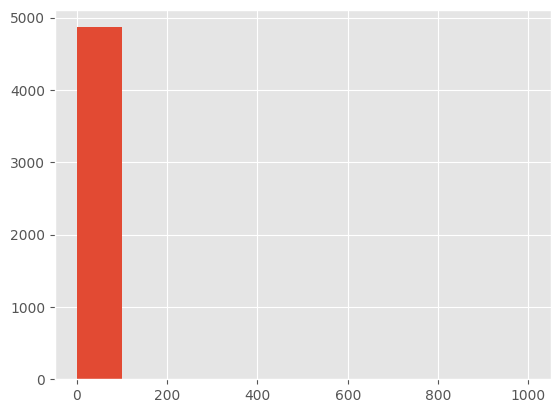

In [133]:
# booking_min_nights
# No NAs
# Choosing to drop anything that requires booking more than 1 month which is only 37 observations. It should be noted that this will lead to us losing
# some information on longterm rentals but I think this is preferable, in particular as these might be faulty observations anyways
# Again similar to raitings etc. 1 very large category and then everything else. Tempted to code as 0/1

#for now: cap at 31
feature_train.loc[feature_train["booking_max_nights"] >31, "booking_max_nights"] = 31
feature_train['booking_min_nights'].hist()
transformed_train = pd.concat([transformed_train,feature_train['booking_min_nights']],axis=1)

In [134]:
# booking_max_nights
# no NAs
# Capped everything above 2 months 
feature_train.loc[feature_train["booking_max_nights"] >60, "booking_max_nights"] = 60
#feature_train['booking_max_nights'].hist()
transformed_train = pd.concat([transformed_train,feature_train['booking_max_nights']],axis=1)

In [135]:
# booking_cancel_policy
# Seems fine
#feature_train['booking_cancel_policy'].hist()

cancel_cat = pd.get_dummies(feature_train['booking_cancel_policy'])
transformed_train = pd.concat([transformed_train,cancel_cat],axis=1)


In [136]:
# booking_availability_30/60/90/365
# No NAs in any of them
# Transform availabilities into representing the availability of respective time periods (e.g. 365-90 day availability = availability for last 9 months)
# Only execute once

feature_train['booking_availability_365'] = feature_train['booking_availability_365']-feature_train['booking_availability_90']
feature_train['booking_availability_90'] = feature_train['booking_availability_90'] - feature_train['booking_availability_60']
feature_train['booking_availability_60'] = feature_train['booking_availability_60']- feature_train['booking_availability_30']

transformed_train = pd.concat([transformed_train,feature_train['booking_availability_30']],axis=1)
transformed_train = pd.concat([transformed_train,feature_train['booking_availability_60']],axis=1)
transformed_train = pd.concat([transformed_train,feature_train['booking_availability_90']],axis=1)
transformed_train = pd.concat([transformed_train,feature_train['booking_availability_365']],axis=1)

In [137]:
# review_first, review_last
# Could add difference between first and last, larger the better, could do some more sophisticated imputing. Chose simply the mode for now
# Also skewed for now




feature_train['reviews_first'] = pd.to_datetime(feature_train['reviews_first'])
reviews_first_mode = feature_train['reviews_first'].mode()[0]
feature_train['reviews_first'] = feature_train['reviews_first'].fillna(feature_train['reviews_first'].mode()[0])

feature_train['reviews_last'] = pd.to_datetime(feature_train['reviews_last'])
reviews_last_mode = feature_train['reviews_last'].mode()[0]
feature_train['reviews_last'] = feature_train['reviews_last'].fillna(feature_train['reviews_last'].mode()[0])

feature_train['reviews_first_since_scraped'] = (feature_train['property_scraped_at'] -feature_train['reviews_first']).dt.days.astype('int16')
feature_train['reviews_last_since_scraped'] =  (feature_train['property_scraped_at'] -feature_train['reviews_last']).dt.days.astype('int16')

feature_train = feature_train.drop(['reviews_first'], axis = 1) # Dropping old columns
feature_train = feature_train.drop(['reviews_last'], axis = 1) # Dropping old columns

transformed_train = pd.concat([transformed_train,feature_train['reviews_first_since_scraped']],axis=1)
transformed_train = pd.concat([transformed_train,feature_train['reviews_last_since_scraped']],axis=1)

In [138]:
# reviews_rating
reviews_rating_mode = feature_train['reviews_rating'].mode()[0]
feature_train['reviews_rating']=feature_train['reviews_rating'].fillna(feature_train['reviews_rating'].mode()[0])

transformed_train = pd.concat([transformed_train,feature_train['reviews_rating']],axis=1)

In [139]:
# reviews_acc
reviews_acc_mode = feature_train['reviews_acc'].mode()[0]
feature_train['reviews_acc']=feature_train['reviews_acc'].fillna(feature_train['reviews_acc'].mode()[0])

transformed_train = pd.concat([transformed_train,feature_train['reviews_acc']],axis=1)

In [140]:
#fix column names
transformed_train.columns = transformed_train.columns.astype(str)

In [141]:
nans = transformed_train.isna().any()
print(nans.loc[nans==True])

Series([], dtype: bool)


In [142]:
eda=AV.AutoViz(filename="",dfte=feature_train)

NameError: name 'AV' is not defined

# Creation of Test Data Set

In [ ]:
# Dropping this would be the same as the word doc table
feature_test = feature_test.drop(['property_id','property_space','property_desc','property_neighborhood','property_notes','property_access',
                                    "property_interaction","property_rules","host_location","host_about","host_id","property_sqfeet"], axis = 1)
feature_test = feature_test.drop(["property_transit"],axis=1)
transformed_test = pd.DataFrame()

In [ ]:
# All df to lower case -works
from sklearn.preprocessing import FunctionTransformer
def toLower(df):
    df = df.apply(lambda x: x.str.lower() if x.dtype=='object' else x)
    return df

toLower = FunctionTransformer(toLower)
toLower.fit_transform(feature_test)

In [ ]:
# Property name: replaced by the word count & new column:missing? - works

feature_test['property_name_miss'] = np.where(feature_test['property_name'].isna(), 1, 0)
# Should refactor this because if run twice it throws an error
feature_test.property_name = feature_test['property_name'].str.split().str.len()
feature_test.property_name = feature_test.property_name.fillna(0)

transformed_test = pd.concat([transformed_test,feature_test.property_name],axis=1)
transformed_test = pd.concat([transformed_test,feature_test.property_name_miss],axis=1)


In [ ]:
# Property summary: new columns - summary_missing & property_summary_count
## Missing = 'nan' or one word in summary
str_df  = pd.DataFrame()
str_df['condition'] = feature_test['property_summary'].str.match(r'\A[\w-]+\Z')

feature_test = pd.merge(str_df, feature_test, left_index=True, right_index=True)
feature_test['property_summary_miss'] = np.where(feature_test['condition'].isna(), 1, 0)
feature_test = feature_test.drop(['condition'], axis = 1)

transformed_test = pd.concat([transformed_test,feature_test.property_summary_miss],axis=1)

In [ ]:
## Property_summary_count: remove numbers, punctuation 
feature_test['property_summary'] = feature_test['property_summary'].str.replace('\d+', '')
feature_test['property_summary'] = feature_test['property_summary'].str.replace('[^\w\s]',' ')

feature_test['property_summary_count'] = feature_test['property_summary'].str.split().str.len()
feature_test = feature_test.drop(['property_summary'], axis = 1)
feature_test.property_summary_count = feature_test.property_summary_count.fillna(0)

transformed_test = pd.concat([transformed_test,feature_test.property_summary_count],axis=1)

In [ ]:
# property_zipcode: replaced with mode

feature_test['property_zipcode'] = feature_test['property_zipcode'] .fillna(zipcode_mode)

feature_test.loc[feature_test['property_zipcode']=='11 20','property_zipcode']=1120

freq_table=feature_test['property_zipcode'].value_counts()

#encoding: preserve 11 most frequent categories
feature_test.property_zipcode=feature_test.property_zipcode.astype(int)
zipcode_cats = pd.get_dummies(feature_test.property_zipcode)
sorted_zipcode_cats = zipcode_cats[zipcode_cats.sum().sort_values(ascending=False).index]

transformed_test = pd.concat([transformed_test,sorted_zipcode_cats.iloc[:,:10]],axis=1)

In [ ]:
# property_type: regrouped into - apartment, house, other
threshold_percent = 3

series = pd.value_counts(feature_test['property_type'])
mask = (series / series.sum() * 100).lt(threshold_percent)

feature_test = feature_test.assign(property_type = np.where(feature_test['property_type'].isin(series[mask].index),'Other', feature_test['property_type']))


In [ ]:
#encode property_type
type_cats = pd.get_dummies(feature_test['property_type'])
transformed_test = pd.concat([transformed_test,type_cats],axis=1)


In [ ]:
# property_bathrooms: regroup into 1. None 2. One 3. More than one
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt

feature_test['property_bathrooms'] =feature_test['property_bathrooms'].fillna(bathrooms_mode)

np.unique(feature_test['property_bathrooms'],return_counts=True)

feature_test['property_bathrooms_cat']= 'One'
feature_test.loc[(feature_test['property_bathrooms'] < 1) , 'property_bathrooms_cat'] = 'None'
feature_test.loc[(feature_test['property_bathrooms'] > 1), 'property_bathrooms_cat'] = 'More than one'

feature_test = feature_test.drop(['property_bathrooms'], axis = 1)
feature_test['property_bathrooms_cat']

bathroom_cats = pd.get_dummies(feature_test['property_bathrooms_cat'])
transformed_test = pd.concat([transformed_test,bathroom_cats],axis=1)

In [ ]:
# property_bedrooms
import matplotlib.pyplot as plt
import plotly.express as px

def NumToCategory(df, column,new_column, missing_value = 0):
  df[column] =df[column].fillna(missing_value)

  df.loc[(df[column] == 1), new_column] = 'One'
  df.loc[(df[column] == 2), new_column] = 'Two'
  df.loc[(df[column] == 3), new_column] = 'Three'
  df.loc[(df[column] > 3), new_column] = 'More than three'

  df = df.drop([column], axis = 1)
  return df

feature_test = NumToCategory(feature_test, 'property_beds', 'property_beds_cat')
feature_test = NumToCategory(feature_test, 'property_bedrooms', 'property_bedrooms_cat')

beds_dummies = pd.get_dummies(feature_test['property_beds_cat'])
bedrooms_dummies = pd.get_dummies(feature_test['property_bedrooms_cat'])

transformed_test = pd.concat([transformed_test,beds_dummies,bedrooms_dummies],axis=1)

In [ ]:
# property_bed_type: ok
feature_test['property_bed_type'].unique()
# room type: ok
pd.value_counts(feature_test['property_room_type'])


roomtype_cat = pd.get_dummies(feature_test['property_room_type'])
transformed_test = pd.concat([transformed_test,roomtype_cat],axis=1)

In [ ]:
# property_amenities: count the number of amenities provided
# remove nans by the mode 

# reviews_num: Power transform for skeweness 

import plotly.express as px
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import skewtest

feature_test['property_amenities'] =  feature_test['property_amenities'].str.split(', ').str.len()
feature_test['property_amenities'] = feature_test['property_amenities'].fillna(amenities_mode)

def powerTransform(df, column):
  col  = np.array( df[column]).reshape(-1, 1)
  pt = PowerTransformer(method='yeo-johnson', standardize=True,) 
  fit = pt.fit(col)
  fit = pt.transform(col)
  df[column] = fit
  return df

feature_test = powerTransform(feature_test,'property_amenities')
feature_test = powerTransform(feature_test,'reviews_num')


transformed_test = pd.concat([transformed_test,feature_test.property_amenities],axis=1)
transformed_test = pd.concat([transformed_test,feature_test.reviews_num],axis=1)

In [ ]:
# reviews_cleanliness
# Good: above 5, Bad: below 5, None: average (could be set to "Missing", but people who find a property okay usually dont leave reviews, hence, average. Missing might be misleading)
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

def reviewRecoding(df, column, new_column):
  df[new_column] = df[column].fillna('Average')
  df.loc[(df[column] <= 5) , new_column] = 'Bad'
  df.loc[(df[column] > 5), new_column] = 'Good'
  df = df.drop([column], axis = 1)

  return df

feature_test = reviewRecoding(feature_test, 'reviews_cleanliness', 'reviews_cleanliness_n')
feature_test = reviewRecoding(feature_test, 'reviews_checkin', 'reviews_checkin_n')
feature_test = reviewRecoding(feature_test, 'reviews_location', 'reviews_communication_n')
feature_test = reviewRecoding(feature_test, 'reviews_communication', 'reviews_communication_n')
feature_test = reviewRecoding(feature_test, 'reviews_value', 'reviews_value_n')

cleanliness_cat = pd.get_dummies(feature_test['reviews_cleanliness_n'])
checkin_cat = pd.get_dummies(feature_test['reviews_checkin_n'])
location_cat = pd.get_dummies(feature_test['reviews_communication_n'])
communication_cat = pd.get_dummies(feature_test['reviews_communication_n'])
value_cat = pd.get_dummies(feature_test['reviews_value_n'])

transformed_test = pd.concat([transformed_test,cleanliness_cat],axis=1)
transformed_test = pd.concat([transformed_test,checkin_cat],axis=1)
transformed_test = pd.concat([transformed_test,location_cat],axis=1)
transformed_test = pd.concat([transformed_test,communication_cat],axis=1)
transformed_test = pd.concat([transformed_test,value_cat],axis=1)


In [ ]:
# reviews_per_month (avg): right skewed - log transform
#add 1 to all to avoid log problems
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

feature_test['reviews_per_month'] =feature_test['reviews_per_month'].fillna(reviews_per_month_mode)
feature_test['reviews_per_month'] =feature_test['reviews_per_month']+1
def reviewsLog(df, feature):
  logTr = ColumnTransformer(transformers=[('lg', FunctionTransformer(np.log),[feature])])
  log = logTr.fit_transform(df)
  df[feature] = log

  return df

feature_test = reviewsLog(feature_test, 'reviews_per_month')
feature_test.reviews_per_month = feature_test.reviews_per_month.fillna(0)

transformed_test = pd.concat([transformed_test,feature_test.reviews_per_month],axis=1)

In [ ]:
# property_scraped_at
feature_test['property_scraped_at']= pd.to_datetime(feature_test['property_scraped_at'])
feature_test['scraped_weekday']=feature_test['property_scraped_at'].dt.weekday

In [ ]:
#encode property_scraped_at
start_year = 2017
days_since_2017 = (feature_test['property_scraped_at'] - pd.Timestamp(str(start_year))).dt.days

transformed_test = pd.concat([transformed_test,days_since_2017],axis=1)


In [ ]:
# property_last_updated
# Naturally last_updated is a string :))))))

def last_updated_conversion(update_var:str):
  # 3 Buckets evenly distributed based on test, 2 for > 3 months, 0 for updated yesterday/today
  if "never" in update_var:
    return "3 months or more"
  elif "month" in update_var:
    if int(update_var.split(" ")[0])>=3:
      return "3 months or more"
    else:
      return "1 week to 3 months"
  elif "week" in update_var:
    return "1 week to 3 months"
  else: # This catches yesterday etc. is actually equivalent to "day" in update_var
    return "Within days"

feature_test["property_last_updated_bucket"] = [last_updated_conversion(x) for x in feature_test["property_last_updated"]] 
feature_test = feature_test.drop(["property_last_updated"], axis = 1) # Dropping old columns

last_updated_cat = pd.get_dummies(feature_test['property_last_updated_bucket'])
transformed_test = pd.concat([transformed_test,last_updated_cat],axis=1)

In [ ]:
# host_since
feature_test['host_since']=pd.to_datetime(feature_test['host_since'])
feature_test['host_since'] = feature_test['host_since'].fillna(host_since_mean) # Simply imputing with mean, only had 1 NA anyways
feature_test['host_since_scraped'] = feature_test['property_scraped_at']-feature_test['host_since']
feature_test['host_since_scraped'] = feature_test['host_since_scraped'].dt.days.astype('int16')
#feature_test['host_since_scraped'].hist()
feature_test = feature_test.drop(['host_since'], axis = 1) # Dropping old columns

transformed_test = pd.concat([transformed_test,feature_test['host_since_scraped']],axis=1)

In [ ]:
# host_response_time
# Given 1k NAN decided to add extra missing category as never having received messages might be a signal, otherwise seems fine
feature_test['host_response_time']=feature_test['host_response_time'].fillna(value="Missing",inplace=True)
#feature_test['host_response_time'].hist()

host_response_cat = pd.get_dummies(feature_test['host_response_time'])
transformed_test = pd.concat([transformed_test,host_response_cat],axis=1)

In [ ]:
# host_response_rate
# Impute 100% response rate for never having received a request which is "fair"
feature_test['host_response_rate']=feature_test['host_response_rate'].fillna(value=100)
# Similar to Rating skewness
#feature_test['host_response_rate'].hist()

transformed_test = pd.concat([transformed_test,feature_test['host_response_rate']],axis=1)

In [ ]:
# host_nr_listings, host_nr_listings_total
# Decided to drop host_nr_listings_total for now as it is basically the same information as host_nr_listings in the testing set,
# if one wants to squeeze more information out one could take the difference between the two as an extra feature
# Basically everyone only has 1 property
if "host_nr_listings_total" in feature_test.columns:
  feature_test = feature_test.drop(['host_nr_listings_total'], axis = 1)

feature_test.loc[(feature_test['host_nr_listings'] <= 1) , 'host_nr_listings_cat'] = 'One or less'
feature_test.loc[(feature_test['host_nr_listings'] > 1) & (feature_test['host_nr_listings'] <=3), 'host_nr_listings_cat'] = 'Two to Three'
feature_test.loc[(feature_test['host_nr_listings'] > 3), 'host_nr_listings_cat'] = 'More than 3'

#feature_test['host_nr_listings_cat'].hist()
feature_test = feature_test.drop(['host_nr_listings'], axis = 1) # Dropping old columns

nr_listings_cat = pd.get_dummies(feature_test['host_nr_listings_cat'])
transformed_test = pd.concat([transformed_test,nr_listings_cat],axis=1)

In [ ]:
# host_verified
# csv sheet including everything that is "verified" e.g. email,phone reviews etc.
# Same procedure as with property_summary
feature_test['host_verified_count'] = feature_test['host_verified'].str.split(",").str.len()
#feature_test['host_verified_count'].hist()
feature_test = feature_test.drop(['host_verified'], axis = 1) # Dropping old columns

transformed_test = pd.concat([transformed_test,feature_test['host_verified_count']],axis=1)

In [ ]:
# booking_price_covers 
# Number of people that can live in the property for the price
# Again similar to raitings etc. 1 very large category and then everything else. Tempted to code as 0/1

#feature_test['booking_price_covers'].hist()

transformed_test = pd.concat([transformed_test,feature_test['booking_price_covers']],axis=1)

In [ ]:
# booking_min_nights
# No NAs
# Choosing to drop anything that requires booking more than 1 month which is only 37 observations. It should be noted that this will lead to us losing
# some information on longterm rentals but I think this is preferable, in particular as these might be faulty observations anyways
# Again similar to raitings etc. 1 very large category and then everything else. Tempted to code as 0/1

#for now: cap at 31
feature_test.loc[feature_test["booking_max_nights"] >31, "booking_max_nights"] = 31
feature_test['booking_min_nights'].hist()
transformed_test = pd.concat([transformed_test,feature_test['booking_min_nights']],axis=1)

In [ ]:
# booking_max_nights
# no NAs
# Capped everything above 2 months 
feature_test.loc[feature_test["booking_max_nights"] >60, "booking_max_nights"] = 60
#feature_test['booking_max_nights'].hist()
transformed_test = pd.concat([transformed_test,feature_test['booking_max_nights']],axis=1)

In [ ]:
# booking_cancel_policy
# Seems fine
#feature_test['booking_cancel_policy'].hist()

cancel_cat = pd.get_dummies(feature_test['booking_cancel_policy'])
transformed_test = pd.concat([transformed_test,cancel_cat],axis=1)
transformed_test['super_strict_30']= 0

In [ ]:
# booking_availability_30/60/90/365
# No NAs in any of them
# Transform availabilities into representing the availability of respective time periods (e.g. 365-90 day availability = availability for last 9 months)
# Only execute once

feature_test['booking_availability_365'] = feature_test['booking_availability_365']-feature_test['booking_availability_90']
feature_test['booking_availability_90'] = feature_test['booking_availability_90'] - feature_test['booking_availability_60']
feature_test['booking_availability_60'] = feature_test['booking_availability_60']- feature_test['booking_availability_30']

transformed_test = pd.concat([transformed_test,feature_test['booking_availability_30']],axis=1)
transformed_test = pd.concat([transformed_test,feature_test['booking_availability_60']],axis=1)
transformed_test = pd.concat([transformed_test,feature_test['booking_availability_90']],axis=1)
transformed_test = pd.concat([transformed_test,feature_test['booking_availability_365']],axis=1)

In [ ]:
# review_first, review_last
# Could add difference between first and last, larger the better, could do some more sophisticated imputing. Chose simply the mode for now
# Also skewed for now
feature_test['reviews_first'] = pd.to_datetime(feature_test['reviews_first'])
feature_test['reviews_first'] = feature_test['reviews_first'].fillna(reviews_first_mode)

feature_test['reviews_last'] = pd.to_datetime(feature_test['reviews_last'])
feature_test['reviews_last'] = feature_test['reviews_last'].fillna(reviews_last_mode)

feature_test['reviews_first_since_scraped'] = (feature_test['property_scraped_at'] -feature_test['reviews_first']).dt.days.astype('int16')
feature_test['reviews_last_since_scraped'] =  (feature_test['property_scraped_at'] -feature_test['reviews_last']).dt.days.astype('int16')

feature_test = feature_test.drop(['reviews_first'], axis = 1) # Dropping old columns
feature_test = feature_test.drop(['reviews_last'], axis = 1) # Dropping old columns

transformed_test = pd.concat([transformed_test,feature_test['reviews_first_since_scraped']],axis=1)
transformed_test = pd.concat([transformed_test,feature_test['reviews_last_since_scraped']],axis=1)

In [ ]:
# reviews_rating
feature_test['reviews_rating']=feature_test['reviews_rating'].fillna(reviews_rating_mode)

transformed_test = pd.concat([transformed_test,feature_test['reviews_rating']],axis=1)

In [ ]:
# reviews_acc
feature_test['reviews_acc']=feature_test['reviews_acc'].fillna(reviews_acc_mode)

transformed_test = pd.concat([transformed_test,feature_test['reviews_acc']],axis=1)

In [ ]:
#fix column names
transformed_test.columns = transformed_test.columns.astype(str)

In [ ]:
nans = transformed_test.isna().any()
print(nans.loc[nans==True])

In [ ]:
print(transformed_train.columns)

In [ ]:
print(transformed_test.columns)

# Modelling

## PCA

In [190]:
from sklearn.decomposition import PCA

pca = PCA()

pca.fit(transformed_train)

print(np.cumsum(pca.explained_variance_ratio_))

[0.66605608 0.89550626 0.96936648 0.99684817 0.99773112 0.99842212
 0.99908064 0.99955835 0.99971077 0.99982181 0.99992667 0.99996803
 0.99997469 0.99997911 0.99998277 0.99998557 0.99998816 0.99998981
 0.99999092 0.99999177 0.99999255 0.99999323 0.99999387 0.9999945
 0.99999509 0.99999564 0.99999616 0.9999966  0.99999701 0.99999737
 0.99999771 0.99999802 0.99999827 0.9999985  0.99999869 0.99999886
 0.99999901 0.99999912 0.99999923 0.99999933 0.99999942 0.99999951
 0.99999959 0.99999965 0.99999969 0.99999974 0.99999978 0.99999983
 0.99999986 0.99999989 0.99999992 0.99999995 0.99999997 0.99999998
 0.99999999 0.99999999 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


In [ ]:
pca4 = PCA(n_components=4)
pca4.fit(transformed_train)

train_PCA = pca4.transform(transformed_train)
test_PCA = pca4.transform(transformed_test)

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create models
lr = LinearRegression()

#fit the models
lr.fit(train_PCA,target_train)

# Predict on new data
y_pred = lr.predict(test_PCA)

mse = mean_squared_error(y_pred,target_test,squared=False)

print("Mean Squared Error lr: {:.2f}".format(mse))

# Print the model coefficients
#print("Model coefficients:", model.coef_)

## Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# Create models
lasso_low = Lasso(alpha=0.5)
lasso_mid = Lasso(alpha=1)
lasso_large = Lasso(alpha=100)

#fit the models
lasso_low.fit(transformed_train,target_train)
lasso_mid.fit(transformed_train,target_train)
lasso_large.fit(transformed_train,target_train)

# Predict on new data
y_pred_low = lasso_low.predict(transformed_test)
y_pred_mid = lasso_mid.predict(transformed_test)
y_pred_large = lasso_large.predict(transformed_test)

mse_low = mean_squared_error(y_pred_low,target_test,squared=False)
mse_mid = mean_squared_error(y_pred_mid,target_test,squared=False)
mse_large = mean_squared_error(y_pred_large,target_test,squared=False)

print("Mean Squared Error lowlasso: {:.2f}".format(mse_low))
print("Mean Squared Error midlasso: {:.2f}".format(mse_mid))
print("Mean Squared Error largelasso: {:.2f}".format(mse_large))

# Print the model coefficients
#print("Model coefficients:", model.coef_)

## Poisson regression

In [ ]:
from sklearn.linear_model import PoissonRegressor

# Create models
poisson = PoissonRegressor()

#fit the models
poisson.fit(train_PCA,target_train)

# Predict on new data
y_pred = lr.predict(test_PCA)

mse = mean_squared_error(y_pred,target_test,squared=False)

#print("Mean Squared Error lr: {:.2f}".format(mse))

# Print the model coefficients
#print("Model coefficients:", model.coef_)

## Neural Network: multi-layer-perceptron

In [ ]:
print(transformed_train.shape)

In [ ]:
from sklearn.neural_network import MLPRegressor

# Create models
mlp = MLPRegressor(hidden_layer_sizes=(75,50),random_state=2023,max_iter=10000)

#fit the models
mlp.fit(transformed_train,target_train)

# Predict on new data
y_pred = mlp.predict(transformed_test)

mse = mean_squared_error(y_pred,target_test,squared=False)

print("Mean Squared Error mlp: {:.2f}".format(mse))

# Print the model coefficients
#print("Model coefficients:", model.coef_)

# Fit Model on full dataset

## Create Full Dataset

In [ ]:
# Dropping this would be the same as the word doc table
feature_full = feature_full.drop(['property_id','property_space','property_desc','property_neighborhood','property_notes','property_access',
                                    "property_interaction","property_rules","host_location","host_about","host_id","property_sqfeet"], axis = 1)
feature_full = feature_full.drop(["property_transit"],axis=1)
transformed_full = pd.DataFrame()

In [ ]:
# All df to lower case -works
from sklearn.preprocessing import FunctionTransformer
def toLower(df):
    df = df.apply(lambda x: x.str.lower() if x.dtype=='object' else x)
    return df

toLower = FunctionTransformer(toLower)
toLower.fit_transform(feature_full)

In [ ]:
# Property name: replaced by the word count & new column:missing? - works

feature_full['property_name_miss'] = np.where(feature_full['property_name'].isna(), 1, 0)
# Should refactor this because if run twice it throws an error
feature_full.property_name = feature_full['property_name'].str.split().str.len()
feature_full.property_name = feature_full.property_name.fillna(0)

transformed_full = pd.concat([transformed_full,feature_full.property_name],axis=1)
transformed_full = pd.concat([transformed_full,feature_full.property_name_miss],axis=1)


In [ ]:
# Property summary: new columns - summary_missing & property_summary_count
## Missing = 'nan' or one word in summary
str_df  = pd.DataFrame()
str_df['condition'] = feature_full['property_summary'].str.match(r'\A[\w-]+\Z')

feature_full = pd.merge(str_df, feature_full, left_index=True, right_index=True)
feature_full['property_summary_miss'] = np.where(feature_full['condition'].isna(), 1, 0)
feature_full = feature_full.drop(['condition'], axis = 1)

transformed_full = pd.concat([transformed_full,feature_full.property_summary_miss],axis=1)

In [ ]:
## Property_summary_count: remove numbers, punctuation 
feature_full['property_summary'] = feature_full['property_summary'].str.replace('\d+', '')
feature_full['property_summary'] = feature_full['property_summary'].str.replace('[^\w\s]',' ')

feature_full['property_summary_count'] = feature_full['property_summary'].str.split().str.len()
feature_full = feature_full.drop(['property_summary'], axis = 1)
feature_full.property_summary_count = feature_full.property_summary_count.fillna(0)

transformed_full = pd.concat([transformed_full,feature_full.property_summary_count],axis=1)

In [ ]:
# property_zipcode: replaced with mode
zipcode_mode=feature_full['property_zipcode'].mode()[0]
feature_full['property_zipcode'] = feature_full['property_zipcode'] .fillna(feature_full['property_zipcode'].mode()[0])

feature_full.loc[feature_full['property_zipcode']=='11 20','property_zipcode']=1120

freq_table=feature_full['property_zipcode'].value_counts()

#encoding: preserve 11 most frequent categories
feature_full.property_zipcode=feature_full.property_zipcode.astype(int)
zipcode_cats = pd.get_dummies(feature_full.property_zipcode)
sorted_zipcode_cats = zipcode_cats[zipcode_cats.sum().sort_values(ascending=False).index]

transformed_full = pd.concat([transformed_full,sorted_zipcode_cats.iloc[:,:10]],axis=1)

In [ ]:
# property_type: regrouped into - apartment, house, other
threshold_percent = 3

series = pd.value_counts(feature_full['property_type'])
mask = (series / series.sum() * 100).lt(threshold_percent)

feature_full = feature_full.assign(property_type = np.where(feature_full['property_type'].isin(series[mask].index),'Other', feature_full['property_type']))


In [ ]:
#encode property_type
type_cats = pd.get_dummies(feature_full['property_type'])
transformed_full = pd.concat([transformed_full,type_cats],axis=1)


In [ ]:
# property_bathrooms: regroup into 1. None 2. One 3. More than one
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt

bathrooms_mode = feature_full['property_bathrooms'].mode()
feature_full['property_bathrooms'] =feature_full['property_bathrooms'].fillna(feature_full['property_bathrooms'].mode())

np.unique(feature_full['property_bathrooms'],return_counts=True)

feature_full['property_bathrooms_cat']= 'One'
feature_full.loc[(feature_full['property_bathrooms'] < 1) , 'property_bathrooms_cat'] = 'None'
feature_full.loc[(feature_full['property_bathrooms'] > 1), 'property_bathrooms_cat'] = 'More than one'

feature_full = feature_full.drop(['property_bathrooms'], axis = 1)
feature_full['property_bathrooms_cat']

bathroom_cats = pd.get_dummies(feature_full['property_bathrooms_cat'])
transformed_full = pd.concat([transformed_full,bathroom_cats],axis=1)

In [ ]:
# property_bedrooms
import matplotlib.pyplot as plt
import plotly.express as px

def NumToCategory(df, column,new_column, missing_value = 0):
  df[column] =df[column].fillna(missing_value)

  df.loc[(df[column] == 1), new_column] = 'One'
  df.loc[(df[column] == 2), new_column] = 'Two'
  df.loc[(df[column] == 3), new_column] = 'Three'
  df.loc[(df[column] > 3), new_column] = 'More than three'

  df = df.drop([column], axis = 1)
  return df

feature_full = NumToCategory(feature_full, 'property_beds', 'property_beds_cat')
feature_full = NumToCategory(feature_full, 'property_bedrooms', 'property_bedrooms_cat')

beds_dummies = pd.get_dummies(feature_full['property_beds_cat'])
bedrooms_dummies = pd.get_dummies(feature_full['property_bedrooms_cat'])

transformed_full = pd.concat([transformed_full,beds_dummies,bedrooms_dummies],axis=1)

In [ ]:
# property_bed_type: ok
feature_full['property_bed_type'].unique()
# room type: ok
pd.value_counts(feature_full['property_room_type'])


roomtype_cat = pd.get_dummies(feature_full['property_room_type'])
transformed_full = pd.concat([transformed_full,roomtype_cat],axis=1)

In [ ]:
# property_amenities: count the number of amenities provided
# remove nans by the mode 

# reviews_num: Power transform for skeweness 

import plotly.express as px
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import skewtest


feature_full['property_amenities'] =  feature_full['property_amenities'].str.split(', ').str.len()
amenities_mode = feature_full['property_amenities'].mode()[0]
feature_full['property_amenities'] = feature_full['property_amenities'].fillna(feature_full['property_amenities'].mode()[0])

def powerTransform(df, column):
  col  = np.array( df[column]).reshape(-1, 1)
  pt = PowerTransformer(method='yeo-johnson', standardize=True,) 
  fit = pt.fit(col)
  fit = pt.transform(col)
  df[column] = fit
  return df

feature_full = powerTransform(feature_full,'property_amenities')
feature_full = powerTransform(feature_full,'reviews_num')


transformed_full = pd.concat([transformed_full,feature_full.property_amenities],axis=1)
transformed_full = pd.concat([transformed_full,feature_full.reviews_num],axis=1)


In [ ]:
# reviews_cleanliness
# Good: above 5, Bad: below 5, None: average (could be set to "Missing", but people who find a property okay usually dont leave reviews, hence, average. Missing might be misleading)
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

def reviewRecoding(df, column, new_column):
  df[new_column] = df[column].fillna('Average')
  df.loc[(df[column] <= 5) , new_column] = 'Bad'
  df.loc[(df[column] > 5), new_column] = 'Good'
  df = df.drop([column], axis = 1)

  return df

feature_full = reviewRecoding(feature_full, 'reviews_cleanliness', 'reviews_cleanliness_n')
feature_full = reviewRecoding(feature_full, 'reviews_checkin', 'reviews_checkin_n')
feature_full = reviewRecoding(feature_full, 'reviews_location', 'reviews_communication_n')
feature_full = reviewRecoding(feature_full, 'reviews_communication', 'reviews_communication_n')
feature_full = reviewRecoding(feature_full, 'reviews_value', 'reviews_value_n')

cleanliness_cat = pd.get_dummies(feature_full['reviews_cleanliness_n'])
checkin_cat = pd.get_dummies(feature_full['reviews_checkin_n'])
location_cat = pd.get_dummies(feature_full['reviews_communication_n'])
communication_cat = pd.get_dummies(feature_full['reviews_communication_n'])
value_cat = pd.get_dummies(feature_full['reviews_value_n'])

transformed_full = pd.concat([transformed_full,cleanliness_cat],axis=1)
transformed_full = pd.concat([transformed_full,checkin_cat],axis=1)
transformed_full = pd.concat([transformed_full,location_cat],axis=1)
transformed_full = pd.concat([transformed_full,communication_cat],axis=1)
transformed_full = pd.concat([transformed_full,value_cat],axis=1)


In [ ]:
# reviews_per_month (avg): right skewed - log transform
#add 1 to all to avoid log problems
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

reviews_per_month_mode = feature_full['reviews_per_month'].mode()

feature_full['reviews_per_month'] =feature_full['reviews_per_month'].fillna(feature_full['reviews_per_month'].mode())
feature_full['reviews_per_month'] =feature_full['reviews_per_month']+1
def reviewsLog(df, feature):
  logTr = ColumnTransformer(transformers=[('lg', FunctionTransformer(np.log),[feature])])
  log = logTr.fit_transform(df)
  df[feature] = log

  return df

feature_full = reviewsLog(feature_full, 'reviews_per_month')
feature_full.reviews_per_month = feature_full.reviews_per_month.fillna(0)

transformed_full = pd.concat([transformed_full,feature_full.reviews_per_month],axis=1)

In [ ]:
# property_scraped_at
feature_full['property_scraped_at']= pd.to_datetime(feature_full['property_scraped_at'])
feature_full['scraped_weekday']=feature_full['property_scraped_at'].dt.weekday

In [ ]:
#encode property_scraped_at
start_year = 2017
days_since_2017 = (feature_full['property_scraped_at'] - pd.Timestamp(str(start_year))).dt.days

transformed_full = pd.concat([transformed_full,days_since_2017],axis=1)


In [ ]:
# property_last_updated
# Naturally last_updated is a string :))))))

def last_updated_conversion(update_var:str):
  # 3 Buckets evenly distributed based on full, 2 for > 3 months, 0 for updated yesterday/today
  if "never" in update_var:
    return "3 months or more"
  elif "month" in update_var:
    if int(update_var.split(" ")[0])>=3:
      return "3 months or more"
    else:
      return "1 week to 3 months"
  elif "week" in update_var:
    return "1 week to 3 months"
  else: # This catches yesterday etc. is actually equivalent to "day" in update_var
    return "Within days"

feature_full["property_last_updated_bucket"] = [last_updated_conversion(x) for x in feature_full["property_last_updated"]] 
feature_full = feature_full.drop(["property_last_updated"], axis = 1) # Dropping old columns

last_updated_cat = pd.get_dummies(feature_full['property_last_updated_bucket'])
transformed_full = pd.concat([transformed_full,last_updated_cat],axis=1)

In [ ]:
# host_since
feature_full['host_since']=pd.to_datetime(feature_full['host_since'])
host_since_mean = feature_full['host_since'].mean()
feature_full['host_since'] = feature_full['host_since'].fillna(host_since_mean) # Simply imputing with mean, only had 1 NA anyways
feature_full['host_since_scraped'] = feature_full['property_scraped_at']-feature_full['host_since']
feature_full['host_since_scraped'] = feature_full['host_since_scraped'].dt.days.astype('int16')
#feature_full['host_since_scraped'].hist()
feature_full = feature_full.drop(['host_since'], axis = 1) # Dropping old columns

transformed_full = pd.concat([transformed_full,feature_full['host_since_scraped']],axis=1)

In [ ]:
# host_response_time
# Given 1k NAN decided to add extra missing category as never having received messages might be a signal, otherwise seems fine
feature_full['host_response_time']=feature_full['host_response_time'].fillna(value="Missing",inplace=True)
#feature_full['host_response_time'].hist()

host_response_cat = pd.get_dummies(feature_full['host_response_time'])
transformed_full = pd.concat([transformed_full,host_response_cat],axis=1)

In [ ]:
# host_response_rate
# Impute 100% response rate for never having received a request which is "fair"
feature_full['host_response_rate']=feature_full['host_response_rate'].fillna(value=100)
# Similar to Rating skewness
#feature_full['host_response_rate'].hist()

transformed_full = pd.concat([transformed_full,feature_full['host_response_rate']],axis=1)

In [ ]:
# host_nr_listings, host_nr_listings_total
# Decided to drop host_nr_listings_total for now as it is basically the same information as host_nr_listings in the fulling set,
# if one wants to squeeze more information out one could take the difference between the two as an extra feature
# Basically everyone only has 1 property
if "host_nr_listings_total" in feature_full.columns:
  feature_full = feature_full.drop(['host_nr_listings_total'], axis = 1)

feature_full.loc[(feature_full['host_nr_listings'] <= 1) , 'host_nr_listings_cat'] = 'One or less'
feature_full.loc[(feature_full['host_nr_listings'] > 1) & (feature_full['host_nr_listings'] <=3), 'host_nr_listings_cat'] = 'Two to Three'
feature_full.loc[(feature_full['host_nr_listings'] > 3), 'host_nr_listings_cat'] = 'More than 3'

#feature_full['host_nr_listings_cat'].hist()
feature_full = feature_full.drop(['host_nr_listings'], axis = 1) # Dropping old columns

nr_listings_cat = pd.get_dummies(feature_full['host_nr_listings_cat'])
transformed_full = pd.concat([transformed_full,nr_listings_cat],axis=1)

In [ ]:
# host_verified
# csv sheet including everything that is "verified" e.g. email,phone reviews etc.
# Same procedure as with property_summary
feature_full['host_verified_count'] = feature_full['host_verified'].str.split(",").str.len()
#feature_full['host_verified_count'].hist()
feature_full = feature_full.drop(['host_verified'], axis = 1) # Dropping old columns

feature_full['host_verified_count'] = feature_full['host_verified_count'].fillna(0)

transformed_full = pd.concat([transformed_full,feature_full['host_verified_count']],axis=1)

In [ ]:
# booking_price_covers 
# Number of people that can live in the property for the price
# Again similar to raitings etc. 1 very large category and then everything else. Tempted to code as 0/1

#feature_full['booking_price_covers'].hist()

transformed_full = pd.concat([transformed_full,feature_full['booking_price_covers']],axis=1)

In [ ]:
# booking_min_nights
# No NAs
# Choosing to drop anything that requires booking more than 1 month which is only 37 observations. It should be noted that this will lead to us losing
# some information on longterm rentals but I think this is preferable, in particular as these might be faulty observations anyways
# Again similar to raitings etc. 1 very large category and then everything else. Tempted to code as 0/1

#for now: cap at 31
feature_full.loc[feature_full["booking_max_nights"] >31, "booking_max_nights"] = 31
feature_full['booking_min_nights'].hist()
transformed_full = pd.concat([transformed_full,feature_full['booking_min_nights']],axis=1)

In [ ]:
# booking_max_nights
# no NAs
# Capped everything above 2 months 
feature_full.loc[feature_full["booking_max_nights"] >60, "booking_max_nights"] = 60
#feature_full['booking_max_nights'].hist()
transformed_full = pd.concat([transformed_full,feature_full['booking_max_nights']],axis=1)

In [ ]:
# booking_cancel_policy
# Seems fine
#feature_full['booking_cancel_policy'].hist()

cancel_cat = pd.get_dummies(feature_full['booking_cancel_policy'])
transformed_full = pd.concat([transformed_full,cancel_cat],axis=1)
transformed_full['super_strict_30']= 0

In [ ]:
# booking_availability_30/60/90/365
# No NAs in any of them
# Transform availabilities into representing the availability of respective time periods (e.g. 365-90 day availability = availability for last 9 months)
# Only execute once

feature_full['booking_availability_365'] = feature_full['booking_availability_365']-feature_full['booking_availability_90']
feature_full['booking_availability_90'] = feature_full['booking_availability_90'] - feature_full['booking_availability_60']
feature_full['booking_availability_60'] = feature_full['booking_availability_60']- feature_full['booking_availability_30']

transformed_full = pd.concat([transformed_full,feature_full['booking_availability_30']],axis=1)
transformed_full = pd.concat([transformed_full,feature_full['booking_availability_60']],axis=1)
transformed_full = pd.concat([transformed_full,feature_full['booking_availability_90']],axis=1)
transformed_full = pd.concat([transformed_full,feature_full['booking_availability_365']],axis=1)

In [ ]:
# review_first, review_last
# Could add difference between first and last, larger the better, could do some more sophisticated imputing. Chose simply the mode for now
# Also skewed for now
feature_full['reviews_first'] = pd.to_datetime(feature_full['reviews_first'])
reviews_first_mode = feature_full['reviews_first'].mode()[0]
feature_full['reviews_first'] = feature_full['reviews_first'].fillna(feature_full['reviews_first'].mode()[0])

feature_full['reviews_last'] = pd.to_datetime(feature_full['reviews_last'])
reviews_last_mode = feature_full['reviews_last'].mode()[0]
feature_full['reviews_last'] = feature_full['reviews_last'].fillna(feature_full['reviews_last'].mode()[0])

feature_full['reviews_first_since_scraped'] = (feature_full['property_scraped_at'] -feature_full['reviews_first']).dt.days.astype('int16')
feature_full['reviews_last_since_scraped'] =  (feature_full['property_scraped_at'] -feature_full['reviews_last']).dt.days.astype('int16')

feature_full = feature_full.drop(['reviews_first'], axis = 1) # Dropping old columns
feature_full = feature_full.drop(['reviews_last'], axis = 1) # Dropping old columns

transformed_full = pd.concat([transformed_full,feature_full['reviews_first_since_scraped']],axis=1)
transformed_full = pd.concat([transformed_full,feature_full['reviews_last_since_scraped']],axis=1)

In [ ]:
# reviews_rating
reviews_rating_mode = feature_full['reviews_rating'].mode()[0]
feature_full['reviews_rating']=feature_full['reviews_rating'].fillna(feature_full['reviews_rating'].mode()[0])

transformed_full = pd.concat([transformed_full,feature_full['reviews_rating']],axis=1)

In [ ]:
# reviews_acc
reviews_acc_mode = feature_full['reviews_acc'].mode()[0]
feature_full['reviews_acc']=feature_full['reviews_acc'].fillna(feature_full['reviews_acc'].mode()[0])

transformed_full = pd.concat([transformed_full,feature_full['reviews_acc']],axis=1)

In [ ]:
#fix column names
transformed_full.columns = transformed_full.columns.astype(str)

In [ ]:
nans = transformed_full.isna().any()
print(nans.loc[nans==True])

## Fit best models on dataset

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()

pca.fit(transformed_full)

print(np.cumsum(pca.explained_variance_ratio_))

In [ ]:
pca4 = PCA(n_components=4)
pca4.fit(transformed_full)

full_PCA = pca4.transform(transformed_full)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create models
lr = LinearRegression()

#fit the models
lr.fit(full_PCA,target_price)


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

lasso_large = Lasso(alpha=100)
lasso_large.fit(transformed_full,target_price)


In [ ]:
from sklearn.neural_network import MLPRegressor

# Create models
mlp = MLPRegressor(hidden_layer_sizes=(75,50),random_state=2023,max_iter=10000)

#fit the models
mlp.fit(transformed_full,target_price)

# Final Prediction Dataset

## Load Final Prediction Dataset

In [ ]:
# Creating train and test data sets (from GitHub, no need to add it manually)
filepath = "https://raw.githubusercontent.com/AnastasiaDv491/AA-datasets/main/test.csv"

feature_val = pd.read_csv(filepath)
feature_val.head()

ids = feature_val.property_id

## Transform Final Prediction Dataset

In [ ]:
# Dropping this would be the same as the word doc table
feature_val = feature_val.drop(['property_id','property_space','property_desc','property_neighborhood','property_notes','property_access',
                                    "property_interaction","property_rules","host_location","host_about","host_id","property_sqfeet"], axis = 1)
feature_val = feature_val.drop(["property_transit"],axis=1)
transformed_val = pd.DataFrame()

In [ ]:
# All df to lower case -works
from sklearn.preprocessing import FunctionTransformer
def toLower(df):
    df = df.apply(lambda x: x.str.lower() if x.dtype=='object' else x)
    return df

toLower = FunctionTransformer(toLower)
toLower.fit_transform(feature_val)

In [ ]:
# Property name: replaced by the word count & new column:missing? - works

feature_val['property_name_miss'] = np.where(feature_val['property_name'].isna(), 1, 0)
# Should refactor this because if run twice it throws an error
feature_val.property_name = feature_val['property_name'].str.split().str.len()
feature_val.property_name = feature_val.property_name.fillna(0)

transformed_val = pd.concat([transformed_val,feature_val.property_name],axis=1)
transformed_val = pd.concat([transformed_val,feature_val.property_name_miss],axis=1)

In [ ]:
# Property summary: new columns - summary_missing & property_summary_count
## Missing = 'nan' or one word in summary
str_df  = pd.DataFrame()
str_df['condition'] = feature_val['property_summary'].str.match(r'\A[\w-]+\Z')

feature_val = pd.merge(str_df, feature_val, left_index=True, right_index=True)
feature_val['property_summary_miss'] = np.where(feature_val['condition'].isna(), 1, 0)
feature_val = feature_val.drop(['condition'], axis = 1)

transformed_val = pd.concat([transformed_val,feature_val.property_summary_miss],axis=1)

In [ ]:
## Property_summary_count: remove numbers, punctuation 
feature_val['property_summary'] = feature_val['property_summary'].str.replace('\d+', '')
feature_val['property_summary'] = feature_val['property_summary'].str.replace('[^\w\s]',' ')

feature_val['property_summary_count'] = feature_val['property_summary'].str.split().str.len()
feature_val = feature_val.drop(['property_summary'], axis = 1)
feature_val.property_summary_count = feature_val.property_summary_count.fillna(0)

transformed_val = pd.concat([transformed_val,feature_val.property_summary_count],axis=1)

In [ ]:
# property_zipcode: replaced with mode
feature_val['property_zipcode'] = feature_val['property_zipcode'] .fillna(zipcode_mode)

feature_val.loc[feature_val['property_zipcode']=='11 20','property_zipcode']=1120

freq_table=feature_val['property_zipcode'].value_counts()

#encoding: preserve 11 most frequent categories
feature_val.property_zipcode=feature_val.property_zipcode.astype(int)
zipcode_cats = pd.get_dummies(feature_val.property_zipcode)

zipcode_cats.columns
sorted_zipcode_cats = zipcode_cats.loc[:,[1000, 1050, 1060, 2000, 1030,1040, 1190, 2018, 1180, 1070]]

transformed_val = pd.concat([transformed_val,sorted_zipcode_cats.iloc[:,:10]],axis=1)

In [ ]:
# property_type: regrouped into - apartment, house, other
threshold_percent = 3

series = pd.value_counts(feature_val['property_type'])
mask = (series / series.sum() * 100).lt(threshold_percent)

feature_val = feature_val.assign(property_type = np.where(feature_val['property_type'].isin(series[mask].index),'Other', feature_val['property_type']))


In [ ]:
#encode property_type
type_cats = pd.get_dummies(feature_val['property_type'])
transformed_val = pd.concat([transformed_val,type_cats],axis=1)

In [ ]:
# property_bathrooms: regroup into 1. None 2. One 3. More than one
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt

feature_val['property_bathrooms'] =feature_val['property_bathrooms'].fillna(bathrooms_mode)

np.unique(feature_val['property_bathrooms'],return_counts=True)

feature_val['property_bathrooms_cat']= 'One'
feature_val.loc[(feature_val['property_bathrooms'] < 1) , 'property_bathrooms_cat'] = 'None'
feature_val.loc[(feature_val['property_bathrooms'] > 1), 'property_bathrooms_cat'] = 'More than one'

feature_val = feature_val.drop(['property_bathrooms'], axis = 1)
feature_val['property_bathrooms_cat']

bathroom_cats = pd.get_dummies(feature_val['property_bathrooms_cat'])
transformed_val = pd.concat([transformed_val,bathroom_cats],axis=1)

In [ ]:
# property_bedrooms
import matplotlib.pyplot as plt
import plotly.express as px

def NumToCategory(df, column,new_column, missing_value = 0):
  df[column] =df[column].fillna(missing_value)

  df.loc[(df[column] == 1), new_column] = 'One'
  df.loc[(df[column] == 2), new_column] = 'Two'
  df.loc[(df[column] == 3), new_column] = 'Three'
  df.loc[(df[column] > 3), new_column] = 'More than three'

  df = df.drop([column], axis = 1)
  return df

feature_val = NumToCategory(feature_val, 'property_beds', 'property_beds_cat')
feature_val = NumToCategory(feature_val, 'property_bedrooms', 'property_bedrooms_cat')

beds_dummies = pd.get_dummies(feature_val['property_beds_cat'])
bedrooms_dummies = pd.get_dummies(feature_val['property_bedrooms_cat'])

transformed_val = pd.concat([transformed_val,beds_dummies,bedrooms_dummies],axis=1)

In [ ]:
# property_bed_type: ok
feature_val['property_bed_type'].unique()
# room type: ok
pd.value_counts(feature_val['property_room_type'])


roomtype_cat = pd.get_dummies(feature_val['property_room_type'])
transformed_val = pd.concat([transformed_val,roomtype_cat],axis=1)

In [ ]:
# property_amenities: count the number of amenities provided
# remove nans by the mode 

# reviews_num: Power transform for skeweness 

import plotly.express as px
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import skewtest


feature_val['property_amenities'] =  feature_val['property_amenities'].str.split(', ').str.len()
feature_val['property_amenities'] = feature_val['property_amenities'].fillna(amenities_mode)

def powerTransform(df, column):
  col  = np.array( df[column]).reshape(-1, 1)
  pt = PowerTransformer(method='yeo-johnson', standardize=True,) 
  fit = pt.fit(col)
  fit = pt.transform(col)
  df[column] = fit
  return df

feature_val = powerTransform(feature_val,'property_amenities')
feature_val = powerTransform(feature_val,'reviews_num')


transformed_val = pd.concat([transformed_val,feature_val.property_amenities],axis=1)
transformed_val = pd.concat([transformed_val,feature_val.reviews_num],axis=1)


In [ ]:
# reviews_cleanliness
# Good: above 5, Bad: below 5, None: average (could be set to "Missing", but people who find a property okay usually dont leave reviews, hence, average. Missing might be misleading)
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

def reviewRecoding(df, column, new_column):
  df[new_column] = df[column].fillna('Average')
  df.loc[(df[column] <= 5) , new_column] = 'Bad'
  df.loc[(df[column] > 5), new_column] = 'Good'
  df = df.drop([column], axis = 1)

  return df

feature_val = reviewRecoding(feature_val, 'reviews_cleanliness', 'reviews_cleanliness_n')
feature_val = reviewRecoding(feature_val, 'reviews_checkin', 'reviews_checkin_n')
feature_val = reviewRecoding(feature_val, 'reviews_location', 'reviews_communication_n')
feature_val = reviewRecoding(feature_val, 'reviews_communication', 'reviews_communication_n')
feature_val = reviewRecoding(feature_val, 'reviews_value', 'reviews_value_n')

cleanliness_cat = pd.get_dummies(feature_val['reviews_cleanliness_n'])
checkin_cat = pd.get_dummies(feature_val['reviews_checkin_n'])
location_cat = pd.get_dummies(feature_val['reviews_communication_n'])
communication_cat = pd.get_dummies(feature_val['reviews_communication_n'])
value_cat = pd.get_dummies(feature_val['reviews_value_n'])

transformed_val = pd.concat([transformed_val,cleanliness_cat],axis=1)
transformed_val = pd.concat([transformed_val,checkin_cat],axis=1)
transformed_val = pd.concat([transformed_val,location_cat],axis=1)
transformed_val = pd.concat([transformed_val,communication_cat],axis=1)
transformed_val = pd.concat([transformed_val,value_cat],axis=1)

In [ ]:
# reviews_per_month (avg): right skewed - log transform
#add 1 to all to avoid log problems
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

feature_val['reviews_per_month'] =feature_val['reviews_per_month'].fillna(reviews_per_month_mode)
feature_val['reviews_per_month'] =feature_val['reviews_per_month']+1
def reviewsLog(df, feature):
  logTr = ColumnTransformer(transformers=[('lg', FunctionTransformer(np.log),[feature])])
  log = logTr.fit_transform(df)
  df[feature] = log

  return df

feature_val = reviewsLog(feature_val, 'reviews_per_month')
feature_val.reviews_per_month = feature_val.reviews_per_month.fillna(0)

transformed_val = pd.concat([transformed_val,feature_val.reviews_per_month],axis=1)

In [ ]:
# property_scraped_at
feature_val['property_scraped_at']= pd.to_datetime(feature_val['property_scraped_at'])
feature_val['scraped_weekday']=feature_val['property_scraped_at'].dt.weekday

In [ ]:
#encode property_scraped_at
start_year = 2017
days_since_2017 = (feature_val['property_scraped_at'] - pd.Timestamp(str(start_year))).dt.days

transformed_val = pd.concat([transformed_val,days_since_2017],axis=1)


In [ ]:
# property_last_updated
# Naturally last_updated is a string :))))))

def last_updated_conversion(update_var:str):
  # 3 Buckets evenly distributed based on val, 2 for > 3 months, 0 for updated yesterday/today
  if "never" in update_var:
    return "3 months or more"
  elif "month" in update_var:
    if int(update_var.split(" ")[0])>=3:
      return "3 months or more"
    else:
      return "1 week to 3 months"
  elif "week" in update_var:
    return "1 week to 3 months"
  else: # This catches yesterday etc. is actually equivalent to "day" in update_var
    return "Within days"

feature_val["property_last_updated_bucket"] = [last_updated_conversion(x) for x in feature_val["property_last_updated"]] 
feature_val = feature_val.drop(["property_last_updated"], axis = 1) # Dropping old columns

last_updated_cat = pd.get_dummies(feature_val['property_last_updated_bucket'])
transformed_val = pd.concat([transformed_val,last_updated_cat],axis=1)

In [ ]:
# host_since
feature_val['host_since']=pd.to_datetime(feature_val['host_since'])
feature_val['host_since'] = feature_val['host_since'].fillna(host_since_mean) # Simply imputing with mean, only had 1 NA anyways
feature_val['host_since_scraped'] = feature_val['property_scraped_at']-feature_val['host_since']
feature_val['host_since_scraped'] = feature_val['host_since_scraped'].dt.days.astype('int16')
#feature_val['host_since_scraped'].hist()
feature_val = feature_val.drop(['host_since'], axis = 1) # Dropping old columns

transformed_val = pd.concat([transformed_val,feature_val['host_since_scraped']],axis=1)

In [ ]:
# host_response_time
# Given 1k NAN decided to add extra missing category as never having received messages might be a signal, otherwise seems fine
feature_val['host_response_time']=feature_val['host_response_time'].fillna(value="Missing",inplace=True)
#feature_val['host_response_time'].hist()

host_response_cat = pd.get_dummies(feature_val['host_response_time'])
transformed_val = pd.concat([transformed_val,host_response_cat],axis=1)

In [ ]:
# host_response_rate
# Impute 100% response rate for never having received a request which is "fair"
feature_val['host_response_rate']=feature_val['host_response_rate'].fillna(value=100)
# Similar to Rating skewness
#feature_val['host_response_rate'].hist()

transformed_val = pd.concat([transformed_val,feature_val['host_response_rate']],axis=1)

In [ ]:
# host_nr_listings, host_nr_listings_total
# Decided to drop host_nr_listings_total for now as it is basically the same information as host_nr_listings in the valing set,
# if one wants to squeeze more information out one could take the difference between the two as an extra feature
# Basically everyone only has 1 property
if "host_nr_listings_total" in feature_val.columns:
  feature_val = feature_val.drop(['host_nr_listings_total'], axis = 1)

feature_val.loc[(feature_val['host_nr_listings'] <= 1) , 'host_nr_listings_cat'] = 'One or less'
feature_val.loc[(feature_val['host_nr_listings'] > 1) & (feature_val['host_nr_listings'] <=3), 'host_nr_listings_cat'] = 'Two to Three'
feature_val.loc[(feature_val['host_nr_listings'] > 3), 'host_nr_listings_cat'] = 'More than 3'

#feature_val['host_nr_listings_cat'].hist()
feature_val = feature_val.drop(['host_nr_listings'], axis = 1) # Dropping old columns

nr_listings_cat = pd.get_dummies(feature_val['host_nr_listings_cat'])
transformed_val = pd.concat([transformed_val,nr_listings_cat],axis=1)

In [ ]:
# host_verified
# csv sheet including everything that is "verified" e.g. email,phone reviews etc.
# Same procedure as with property_summary
feature_val['host_verified_count'] = feature_val['host_verified'].str.split(",").str.len()
#feature_val['host_verified_count'].hist()
feature_val = feature_val.drop(['host_verified'], axis = 1) # Dropping old columns

feature_val['host_verified_count'] = feature_val['host_verified_count'].fillna(0)

transformed_val = pd.concat([transformed_val,feature_val['host_verified_count']],axis=1)

In [ ]:
# booking_price_covers 
# Number of people that can live in the property for the price
# Again similar to raitings etc. 1 very large category and then everything else. Tempted to code as 0/1

#feature_val['booking_price_covers'].hist()

transformed_val = pd.concat([transformed_val,feature_val['booking_price_covers']],axis=1)

In [ ]:
# booking_min_nights
# No NAs
# Choosing to drop anything that requires booking more than 1 month which is only 37 observations. It should be noted that this will lead to us losing
# some information on longterm rentals but I think this is preferable, in particular as these might be faulty observations anyways
# Again similar to raitings etc. 1 very large category and then everything else. Tempted to code as 0/1

#for now: cap at 31
feature_val.loc[feature_val["booking_max_nights"] >31, "booking_max_nights"] = 31
feature_val['booking_min_nights'].hist()
transformed_val = pd.concat([transformed_val,feature_val['booking_min_nights']],axis=1)

In [ ]:
# booking_max_nights
# no NAs
# Capped everything above 2 months 
feature_val.loc[feature_val["booking_max_nights"] >60, "booking_max_nights"] = 60
#feature_val['booking_max_nights'].hist()
transformed_val = pd.concat([transformed_val,feature_val['booking_max_nights']],axis=1)

In [ ]:
# booking_cancel_policy
# Seems fine
#feature_val['booking_cancel_policy'].hist()

cancel_cat = pd.get_dummies(feature_val['booking_cancel_policy'])
transformed_val = pd.concat([transformed_val,cancel_cat],axis=1)
transformed_val['super_strict_30']= 0

In [ ]:
# booking_availability_30/60/90/365
# No NAs in any of them
# Transform availabilities into representing the availability of respective time periods (e.g. 365-90 day availability = availability for last 9 months)
# Only execute once

feature_val['booking_availability_365'] = feature_val['booking_availability_365']-feature_val['booking_availability_90']
feature_val['booking_availability_90'] = feature_val['booking_availability_90'] - feature_val['booking_availability_60']
feature_val['booking_availability_60'] = feature_val['booking_availability_60']- feature_val['booking_availability_30']

transformed_val = pd.concat([transformed_val,feature_val['booking_availability_30']],axis=1)
transformed_val = pd.concat([transformed_val,feature_val['booking_availability_60']],axis=1)
transformed_val = pd.concat([transformed_val,feature_val['booking_availability_90']],axis=1)
transformed_val = pd.concat([transformed_val,feature_val['booking_availability_365']],axis=1)

In [ ]:
# review_first, review_last
# Could add difference between first and last, larger the better, could do some more sophisticated imputing. Chose simply the mode for now
# Also skewed for now
feature_val['reviews_first'] = pd.to_datetime(feature_val['reviews_first'])
feature_val['reviews_first'] = feature_val['reviews_first'].fillna(reviews_first_mode)

feature_val['reviews_last'] = pd.to_datetime(feature_val['reviews_last'])
feature_val['reviews_last'] = feature_val['reviews_last'].fillna(reviews_last_mode)

feature_val['reviews_first_since_scraped'] = (feature_val['property_scraped_at'] -feature_val['reviews_first']).dt.days.astype('int16')
feature_val['reviews_last_since_scraped'] =  (feature_val['property_scraped_at'] -feature_val['reviews_last']).dt.days.astype('int16')

feature_val = feature_val.drop(['reviews_first'], axis = 1) # Dropping old columns
feature_val = feature_val.drop(['reviews_last'], axis = 1) # Dropping old columns

transformed_val = pd.concat([transformed_val,feature_val['reviews_first_since_scraped']],axis=1)
transformed_val = pd.concat([transformed_val,feature_val['reviews_last_since_scraped']],axis=1)

In [ ]:
# reviews_rating
feature_val['reviews_rating']=feature_val['reviews_rating'].fillna(reviews_rating_mode)

transformed_val = pd.concat([transformed_val,feature_val['reviews_rating']],axis=1)

In [ ]:
# reviews_acc
feature_val['reviews_acc']=feature_val['reviews_acc'].fillna(reviews_acc_mode)

transformed_val = pd.concat([transformed_val,feature_val['reviews_acc']],axis=1)

In [ ]:
#fix column names
transformed_val.columns = transformed_val.columns.astype(str)

In [ ]:
nans = transformed_val.isna().any()
print(nans.loc[nans==True])

In [ ]:
print(transformed_full.columns)

In [ ]:
print(transformed_val.columns)

## Predict Prices

In [ ]:
val_PCA = pca4.transform(transformed_val)

price_pred_lr = lr.predict(val_PCA)

#print(price_pred)

In [ ]:
#convert to csv

price_pred_lr=price_pred_lr.flatten('C')
price_pred_lr=price_pred_lr.round(decimals=4)
df=pd.DataFrame({'ID':ids,'PRED':price_pred_lr})
df
df.to_csv('price_pred_lr.csv',index=False,sep=',')

In [ ]:
price_pred_lasso = lasso_large.predict(transformed_val)

In [ ]:
price_pred_lasso=price_pred_lasso.flatten('C')
price_pred_lasso=price_pred_lasso.round(decimals=4)
df=pd.DataFrame({'ID':ids,'PRED':price_pred_lasso})
df
df.to_csv('price_pred_lasso.csv',index=False,sep=',')

In [ ]:
price_pred_mlp = mlp.predict(transformed_val)

In [ ]:
price_pred_mlp=price_pred_mlp.flatten('C')
price_pred_mlp=price_pred_mlp.round(decimals=4)
df=pd.DataFrame({'ID':ids,'PRED':price_pred_mlp})
df
df.to_csv('price_pred_mlp.csv',index=False,sep=',')